In [1]:
{-# LANGUAGE OverloadedStrings #-}

import Network.Wreq
import Data.Aeson.Lens
import Control.Lens

In [2]:
import qualified Data.Text.IO as T

geonamesUsername <- T.readFile ".geonames-username"

In [3]:
{-# LANGUAGE GeneralizedNewtypeDeriving #-}

import Data.String (IsString)
import qualified Data.Text as T

newtype GithubRepo = GithubRepo { unGithubRepo :: T.Text } deriving (IsString, Show)
newtype GithubUser = GithubUser { unGithubUser :: T.Text } deriving (IsString, Show)
newtype CountryCode = CountryCode { unCountryCode :: T.Text } deriving (IsString, Show)
newtype CountryName = CountryName { unCountryName :: T.Text } deriving (IsString, Show)
newtype CountryPopulation = CountryPopulation { unCountryPopulation :: Int } 
    deriving (Num, Enum, Eq, Ord, Real, Integral, Show)

data Country = Country 
    { countryName :: CountryName
    , countryPopulation :: CountryPopulation
    } deriving Show

In [4]:
import Data.Semigroup

githubAPI :: String
geonamesAPI :: String

githubAPI = "https://api.github.com"
geonamesAPI = "http://api.geonames.org"

githubAPISearchRepos :: String
githubAPIRepos :: GithubRepo -> String
githubAPIUsers :: GithubUser -> String
githubAPIRepoContributors :: GithubRepo -> String
geonamesAPISearch :: String
geonamesAPICountryInfo :: String

githubAPISearchRepos = githubAPI <> "/search/repositories"
githubAPIRepos (GithubRepo repo) = githubAPI <> "/repos/" <> T.unpack repo
githubAPIUsers (GithubUser user) = githubAPI <> "/users/" <> T.unpack user
githubAPIRepoContributors repo = githubAPIRepos repo <> "/contributors"
geonamesAPISearch = geonamesAPI <> "/searchJSON"
geonamesAPICountryInfo = geonamesAPI <> "/countryInfoJSON"

In [5]:
import Control.Monad

geonamesError r = r ^? responseBody . key "status" . to show

findCountryCode :: T.Text -> IO (Maybe CountryCode)
findCountryCode location = do
    r <- getWith opts geonamesAPISearch
    forM_ (geonamesError r) $ \e ->
        fail ("At " <> T.unpack location <> ": " <> e)
    pure $ CountryCode <$> 
        r ^? responseBody 
            . key "geonames" 
            . nth 0
            . key "countryCode"
            . _String
  where
    opts = 
        defaults 
            & param "q" .~ [location] 
            & param "username" .~ [geonamesUsername]

In [6]:
countryByCountryCode :: CountryCode -> IO (Maybe Country)
countryByCountryCode (CountryCode code) = do
    r <- getWith opts geonamesAPICountryInfo
    forM_ (geonamesError r) $ \e -> 
        fail ("At " <> T.unpack code <> ": " <> e)
    pure $ Country 
        <$> (fmap CountryName $ r
                ^? responseBody 
                . key "geonames" 
                . nth 0 
                . key "countryName" 
                . _String) 
        <*> (fmap CountryPopulation $ r 
                ^? responseBody
                . key "geonames"
                . nth 0
                . key "population"
                . _String
                . to (read . T.unpack))     
  where
    opts = 
      defaults
          & param "country" .~ [ code ]
          & param "username" .~ [ geonamesUsername ]

In [7]:
import qualified Data.ByteString as BS

githubAuth <- oauth2Token <$> BS.readFile ".github-api-token"

In [8]:
import Control.Monad.Trans.Maybe

githubUserCountry :: GithubUser -> IO (Maybe Country)
githubUserCountry user = runMaybeT $ do
    location <- MaybeT $ getLocation <$> fetchUser
    code <- MaybeT $ findCountryCode location
    MaybeT $ countryByCountryCode code
  where
    fetchUser = getWith opts $ githubAPIUsers user
    getLocation r = r ^? responseBody . key "location" . _String
    opts = defaults & auth ?~ githubAuth

In [9]:
{-# LANGUAGE RankNTypes #-}

import Data.Conduit
import Data.Function (fix)
import Data.ByteString.Lens
import qualified Data.ByteString.Lazy as BL

import Control.Monad.IO.Class (liftIO)
import qualified Data.Conduit.Combinators as C

getAllWith :: Options -> String -> Producer IO (Response BL.ByteString)
getAllWith opts = fix $ \loop url -> do
      r <- liftIO (getWith opts url)
      yield r
      mapM_ loop $ r ^? responseLink "rel" "next" . linkURL . unpackedChars
        
topRepos :: T.Text -> Producer IO GithubRepo   
topRepos language = 
    getAllWith opts githubAPISearchRepos
    .| awaitForever (C.yieldMany . fmap GithubRepo . getFullName)
  where
    getFullName r = 
      r ^.. responseBody . key "items" . values . key "full_name" . _String
    opts = defaults 
        & param "q" .~ ["language:" <> language]
        & param "sort" .~ ["stars"]
        & param "per_page" .~ ["100"]
        & auth ?~ githubAuth

In [10]:
repoContributors :: GithubRepo -> Producer IO GithubUser
repoContributors repo = 
    getAllWith opts (githubAPIRepoContributors repo)
    .| awaitForever (C.yieldMany . fmap GithubUser . getLogin)
  where
    getLogin r = r ^.. responseBody .values.key "login" . _String
    opts = defaults 
        & param "per_page" .~ ["100"]
        & auth ?~ githubAuth

In [11]:
{-# LANGUAGE LambdaCase #-}

import qualified Data.HashSet as Set
import Data.Hashable (Hashable(..))

accumulateUniques :: (Eq a, Hashable a) => Int -> Sink a IO (Set.HashSet a)
accumulateUniques n = go mempty
    where
      go acc = await >>= \case
          Just x | Set.size acc < n -> go (Set.insert x acc)
          _ -> pure acc    

In [12]:
{-# LANGUAGE StandaloneDeriving #-}

deriving instance Eq GithubUser
deriving instance Hashable GithubUser

In [13]:
{-# LANGUAGE DeriveGeneric #-}
{-# LANGUAGE ViewPatterns #-}

import qualified Data.Aeson as Aeson
import GHC.Generics (Generic)
import qualified Data.Binary as B
import qualified Database.LevelDB as DB
import Data.Default
import Control.Monad.Trans.Resource

deriving instance Generic GithubUser
deriving instance Generic Country
deriving instance Generic CountryName
deriving instance Generic CountryPopulation

instance B.Binary GithubUser
instance B.Binary CountryName
instance B.Binary CountryPopulation
instance B.Binary Country

cached :: (B.Binary a, B.Binary b) => (a -> IO b) -> ((a -> ResourceT IO b) -> ResourceT IO c) -> IO c
cached fetch act = runResourceT $ do
    db <- DB.open ".cache" def {DB.createIfMissing = True}
    act $ \key'@(BL.toStrict . B.encode -> key) -> do
        (fmap $ B.decode . BL.fromStrict) <$> DB.get db def key >>= \case
            Just x -> pure x
            Nothing -> do
                x <- liftIO $ fetch key'
                DB.put db def key (BL.toStrict $ B.encode x)
                pure x

In [14]:
import qualified Data.HashMap.Strict as Map
import Control.Monad

deriving instance Eq CountryPopulation
deriving instance Eq CountryName
deriving instance Eq Country
instance Hashable Country where hashWithSalt s = hashWithSalt s . unCountryName . countryName
            
userCountries :: Set.HashSet GithubUser -> IO (Map.HashMap Country Int)
userCountries cs = cached githubUserCountry $ \githubUserCountry' ->
  foldM 
    (\m u -> githubUserCountry' u >>= \case
        Nothing -> pure m
        Just c -> pure $ Map.insertWith (+) c 1 m    
    ) Map.empty (Set.toList cs)

In [15]:
import Graphics.Rendering.Chart 
import Graphics.Rendering.Chart.Backend.Cairo
import Data.Default.Class
import Control.Lens

chart :: String -> [(Country, Double)] -> Renderable ()
chart title cs = toRenderable layout 
  where
    layout = pie_title .~ title
           $ pie_plot . pie_data .~ map pitem values
           $ def
    values = take 10
           . (ix 0. _3 .~ 20) 
           . fmap (\(c, val) -> (T.unpack $ unCountryName $ countryName c, val, 0))
            $ cs
    pitem (s,v,o) = pitem_value .~ v
                  $ pitem_label .~ s
                  $ pitem_offset .~ o
                  $ def

In [16]:
import Data.Bifunctor
import Data.List

Users: 100

Countries: 22

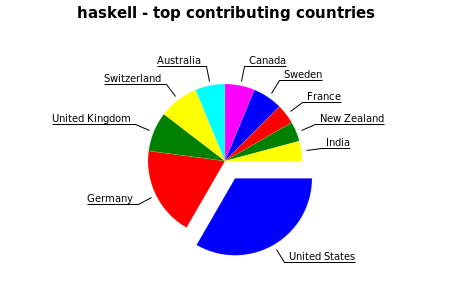

In [17]:
let lang = "haskell"
    title = "top contributing countries"

users <- topRepos lang $$ awaitForever repoContributors .| accumulateUniques 100
    
countries <- userCountries users

putStrLn $ "Users: " <> show (Set.size users)
putStrLn $ "Countries: " <> show (Map.size countries)

chart (lang <> " - " <> title) 
    . sortOn (negate . snd) 
    . fmap (second fromIntegral)
    $ Map.toList countries